# Vanilla, Multi Hop and Graph RAG with open source Model and Hugging face pipeline

In [1]:
!pip3 install langchain
!pip install -U langchain-community
!pip3 install chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.9 MB/s eta 0:00:00


In [1]:
!pip install faiss-gpu-cu11==1.10.0

In [2]:
import os
import re
from typing import List, Dict, Any, Tuple, Optional
from dataclasses import dataclass
import networkx as nx
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
import spacy
from pathlib import Path

In [ ]:
@dataclass
class RAGResult:
    answer: str
    retrieved_docs: List[str]
    method: str
    limitations: List[str]
    reasoning_steps: List[str] = None

In [ ]:
class DocumentLoader:
    """Utility class for loading documents from various sources"""

    @staticmethod
    def load_from_file(file_path: str) -> str:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except Exception as e:
            raise ValueError(f"Error loading file {file_path}: {str(e)}")


In [ ]:
class VanillaRAG:
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.embeddings = HuggingFaceEmbeddings(model_name=model_name)
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        self.vectorstore = None
        self.llm = self._setup_llm()

    def _setup_llm(self):
        """Setup a LLM for generation"""
        model_name = "microsoft/DialoGPT-medium"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name)

        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_length=200,
            temperature=0.7,
            do_sample=True,
            device=0 if torch.cuda.is_available() else -1
        )
        return HuggingFacePipeline(pipeline=pipe)

    def setup_documents(self, documents: List[str]):
        """Process and index documents"""
        docs = []
        for i, doc in enumerate(documents):
            chunks = self.text_splitter.split_text(doc)
            for chunk in chunks:
                docs.append(Document(page_content=chunk, metadata={"source": f"doc_{i}"}))

        self.vectorstore = FAISS.from_documents(docs, self.embeddings)

    def query(self, question: str, k: int = 3) -> RAGResult:
        """Perform vanilla RAG query"""
        if not self.vectorstore:
            raise ValueError("Documents not set up. Call setup_documents first.")

        # Retrieve relevant documents
        retrieved_docs = self.vectorstore.similarity_search(question, k=k)

        # Create context from retrieved documents
        context = "\n\n".join([doc.page_content for doc in retrieved_docs])

        # Generate answer using simple template
        prompt = f"""Context: {context}

        Question: {question}

        Answer based on the context provided:"""

        try:
            answer = self.llm(prompt)
            if isinstance(answer, str):
                answer = answer.strip()
            else:
                answer = str(answer).strip()
        except Exception as e:
            answer = f"Error generating answer: {str(e)}"

        limitations = [
            "Cannot connect information across multiple documents effectively",
            "Struggles with complex queries requiring multiple reasoning steps",
            "Limited by chunk size and may miss relevant context",
            "No understanding of relationships between entities"
        ]

        return RAGResult(
            answer=answer,
            retrieved_docs=[doc.page_content for doc in retrieved_docs],
            method="Vanilla RAG",
            limitations=limitations,
            reasoning_steps=["1. Embed query", "2. Retrieve similar chunks", "3. Generate answer from context"]
        )

In [ ]:
class GraphRAG:
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.embeddings = HuggingFaceEmbeddings(model_name=model_name)
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        self.graph = nx.Graph()
        self.entity_embeddings = {}
        self.llm = self._setup_llm()
        # Load spaCy model for entity recognition
        try:
            self.nlp = spacy.load("en_core_web_sm")
        except OSError:
            print("Warning: spaCy model not found. Install with: python -m spacy download en_core_web_sm")
            self.nlp = None

    def _setup_llm(self):
        """Setup LLM for generation"""
        model_name = "microsoft/DialoGPT-medium"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name)

        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_length=200,
            temperature=0.7,
            do_sample=True,
            device=0 if torch.cuda.is_available() else -1
        )
        return HuggingFacePipeline(pipeline=pipe) # ??????

    def _extract_entities_and_relations(self, text: str) -> List[Tuple[str, str, str]]:
        """Extract entities and relations from text"""
        relations = []

        if self.nlp:
            doc = self.nlp(text)
            entities = [(ent.text, ent.label_) for ent in doc.ents]
        else:
            # Enhanced regex-based entity extraction
            entities = []
            # Company names
            companies = re.findall(r'\b(?:Tesla|SpaceX|Apple|Google|Microsoft|Amazon|PayPal|eBay)\b', text)
            for company in companies:
                entities.append((company, "ORG"))

            # Person names (capitalized words)
            names = re.findall(r'\b[A-Z][a-z]+\s+[A-Z][a-z]+\b', text)
            for name in names:
                entities.append((name, "PERSON"))

            # Products
            products = re.findall(r'\b(?:Model S|Model 3|Model X|Model Y|Falcon 9|Falcon Heavy|Dragon|Starship)\b', text)
            for product in products:
                entities.append((product, "PRODUCT"))

        # Enhanced relation extraction
        sentences = text.split('.')
        for sentence in sentences:
            sentence = sentence.strip()
            if not sentence:
                continue

            # CEO/Leadership relations
            ceo_patterns = [
                r'([A-Z][a-zA-Z\s]+)\s+(?:serves as|is the|was the)\s+(?:CEO|Chief Executive Officer|founder|president)\s+(?:of\s+)?([A-Z][a-zA-Z\s]+)',
                r'([A-Z][a-zA-Z\s]+)\s+(?:founded|established|created)\s+([A-Z][a-zA-Z\s]+)',
                r'([A-Z][a-zA-Z\s]+)\s+(?:leads|manages|runs)\s+([A-Z][a-zA-Z\s]+)'
            ]

            for pattern in ceo_patterns:
                matches = re.findall(pattern, sentence)
                for match in matches:
                    if len(match) == 2:
                        person, company = match
                        relations.append((person.strip(), "CEO_OF", company.strip()))
                        relations.append((person.strip(), "LEADS", company.strip()))

            # Company relations
            company_patterns = [
                r'([A-Z][a-zA-Z\s]+)\s+(?:and|,)\s+([A-Z][a-zA-Z\s]+)\s+(?:are both|share|have)',
                r'([A-Z][a-zA-Z\s]+)\s+(?:collaborates with|partners with|works with)\s+([A-Z][a-zA-Z\s]+)',
                r'([A-Z][a-zA-Z\s]+)\s+(?:acquired|bought|purchased)\s+([A-Z][a-zA-Z\s]+)'
            ]

            for pattern in company_patterns:
                matches = re.findall(pattern, sentence)
                for match in matches:
                    if len(match) == 2:
                        entity1, entity2 = match
                        relations.append((entity1.strip(), "RELATED_TO", entity2.strip()))

            # Product relations
            product_patterns = [
                r'([A-Z][a-zA-Z\s]+)\s+(?:produces|manufactures|makes|develops)\s+([A-Z][a-zA-Z\s]+)',
                r'([A-Z][a-zA-Z\s]+)\s+(?:includes|offers|provides)\s+([A-Z][a-zA-Z\s]+)'
            ]

            for pattern in product_patterns:
                matches = re.findall(pattern, sentence)
                for match in matches:
                    if len(match) == 2:
                        company, product = match
                        relations.append((company.strip(), "PRODUCES", product.strip()))

        return relations

    def setup_documents(self, documents: List[str]):
        """Process documents and build knowledge graph"""
        for i, doc in enumerate(documents):
            chunks = self.text_splitter.split_text(doc)

            for chunk in chunks:
                # Extract entities and relations
                relations = self._extract_entities_and_relations(chunk)

                # Add to graph
                for entity1, relation, entity2 in relations:
                    self.graph.add_edge(entity1, entity2, relation=relation, source=f"doc_{i}")

                    # Store embeddings for entities
                    if entity1 not in self.entity_embeddings:
                        self.entity_embeddings[entity1] = self.embeddings.embed_query(entity1)
                    if entity2 not in self.entity_embeddings:
                        self.entity_embeddings[entity2] = self.embeddings.embed_query(entity2)

    def _find_relevant_entities(self, question: str, k: int = 5) -> List[str]:
        """Find entities most relevant to the question"""
        question_embedding = self.embeddings.embed_query(question)

        similarities = []
        for entity, embedding in self.entity_embeddings.items():
            similarity = np.dot(question_embedding, embedding) / (
                np.linalg.norm(question_embedding) * np.linalg.norm(embedding)
            )
            similarities.append((entity, similarity))

        # Sort by similarity and return top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return [entity for entity, _ in similarities[:k]]

    def _get_subgraph_context(self, entities: List[str], max_depth: int = 2) -> Tuple[str, List[str]]:
        """Get context from subgraph around relevant entities"""
        subgraph_nodes = set()
        reasoning_steps = []

        for entity in entities:
            if entity in self.graph:
                # Add neighbors up to max_depth
                for depth in range(max_depth + 1):
                    if depth == 0:
                        subgraph_nodes.add(entity)
                        reasoning_steps.append(f"Starting from entity: {entity}")
                    else:
                        current_level = list(subgraph_nodes)
                        new_nodes = set()
                        for node in current_level:
                            if node in self.graph:
                                neighbors = list(self.graph.neighbors(node))
                                new_nodes.update(neighbors)
                        subgraph_nodes.update(new_nodes)
                        reasoning_steps.append(f"Depth {depth}: Added {len(new_nodes)} connected entities")

        # Build context from subgraph
        context_parts = []
        for node in subgraph_nodes:
            if node in self.graph:
                neighbors = list(self.graph.neighbors(node))
                if neighbors:
                    relations = []
                    for neighbor in neighbors:
                        edge_data = self.graph.get_edge_data(node, neighbor)
                        if edge_data and 'relation' in edge_data:
                            relations.append(f"{node} {edge_data['relation']} {neighbor}")

                    if relations:
                        context_parts.extend(relations)

        reasoning_steps.append(f"Generated {len(context_parts)} relationship statements")
        return ". ".join(context_parts), reasoning_steps

    def query(self, question: str, k: int = 5) -> RAGResult:
        """Perform graph RAG query"""
        if not self.graph.nodes():
            raise ValueError("Graph not built. Call setup_documents first.")

        reasoning_steps = []

        # Find relevant entities
        relevant_entities = self._find_relevant_entities(question, k)
        reasoning_steps.append(f"Found {len(relevant_entities)} relevant entities: {', '.join(relevant_entities)}")

        # Get subgraph context
        context, graph_reasoning = self._get_subgraph_context(relevant_entities)
        reasoning_steps.extend(graph_reasoning)

        # Generate answer
        prompt = f"""Knowledge Graph Context: {context}

        Question: {question}

        Answer based on the knowledge graph relationships:"""

        try:
            answer = self.llm(prompt)
            answer = str(answer).strip()
        except Exception as e:
            answer = f"Error generating answer: {str(e)}"

        limitations = [
            "Entity extraction quality depends on NLP model accuracy",
            "Relation extraction is often incomplete or incorrect",
            "Graph construction can be noisy with false connections",
            "Requires significant preprocessing and graph maintenance"
        ]

        return RAGResult(
            answer=answer,
            retrieved_docs=[f"Graph context: {context}"],
            method="Graph RAG",
            limitations=limitations,
            reasoning_steps=reasoning_steps
        )


In [ ]:
class MultiHopRAG:
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.embeddings = HuggingFaceEmbeddings(model_name=model_name)
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        self.vectorstore = None
        self.llm = self._setup_llm()
        self.max_hops = 3

    def _setup_llm(self):
        """Setup LLM for generation and query reformulation"""
        model_name = "microsoft/DialoGPT-medium"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name)

        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_length=200,
            temperature=0.7,
            do_sample=True,
            device=0 if torch.cuda.is_available() else -1
        )
        return HuggingFacePipeline(pipeline=pipe)

    def setup_documents(self, documents: List[str]):
        """Process and index documents"""
        docs = []
        for i, doc in enumerate(documents):
            chunks = self.text_splitter.split_text(doc)
            for chunk in chunks:
                docs.append(Document(page_content=chunk, metadata={"source": f"doc_{i}"}))

        self.vectorstore = FAISS.from_documents(docs, self.embeddings)

    def _generate_follow_up_queries(self, original_query: str, context: str) -> List[str]:
        """Generate follow-up queries based on retrieved context"""
        # Extract key entities and concepts for follow-up queries
        follow_up_queries = []

        # Simple heuristic-based query generation
        if "CEO" in original_query or "founder" in original_query.lower():
            follow_up_queries.append("leadership roles other companies")

        if "connection" in original_query.lower() or "relationship" in original_query.lower():
            follow_up_queries.append("shared leadership common person")

        if "compare" in original_query.lower() or "difference" in original_query.lower():
            follow_up_queries.append("business model strategy goals")

        # Extract names from context for more specific queries
        names = re.findall(r'\b[A-Z][a-z]+\s+[A-Z][a-z]+\b', context)
        companies = re.findall(r'\b(?:Tesla|SpaceX|Apple|Google|Microsoft|Amazon)\b', context)

        for name in names[:2]:  # Limit to 2 names
            follow_up_queries.append(f"{name} other companies roles")

        for company in companies[:2]:  # Limit to 2 companies
            follow_up_queries.append(f"{company} business operations")

        return follow_up_queries[:3]  # Return top 3 follow-up queries

    def query(self, question: str, k: int = 3) -> RAGResult:
        """Perform multi-hop RAG query"""
        if not self.vectorstore:
            raise ValueError("Documents not set up. Call setup_documents first.")

        all_retrieved_docs = []
        current_query = question
        accumulated_context = ""
        reasoning_steps = []

        # Initial retrieval
        retrieved_docs = self.vectorstore.similarity_search(current_query, k=k)
        all_retrieved_docs.extend(retrieved_docs)
        accumulated_context = "\n\n".join([doc.page_content for doc in retrieved_docs])
        reasoning_steps.append(f"Hop 1: Retrieved {len(retrieved_docs)} documents for '{current_query}'")

        # Generate follow-up queries and perform additional hops
        follow_up_queries = self._generate_follow_up_queries(question, accumulated_context)

        for i, follow_up_query in enumerate(follow_up_queries):
            hop_docs = self.vectorstore.similarity_search(follow_up_query, k=k)

            # Add unique documents
            unique_docs = []
            for doc in hop_docs:
                if doc.page_content not in [d.page_content for d in all_retrieved_docs]:
                    unique_docs.append(doc)
                    all_retrieved_docs.append(doc)
                    accumulated_context += f"\n\n{doc.page_content}"

            reasoning_steps.append(f"Hop {i+2}: Follow-up query '{follow_up_query}' retrieved {len(unique_docs)} new documents")

        # Generate final answer
        prompt = f"""Context: {accumulated_context}

        Question: {question}

        Answer based on the comprehensive context provided:"""

        try:
            answer = self.llm(prompt)
            answer = str(answer).strip()
        except Exception as e:
            answer = f"Error generating answer: {str(e)}"

        limitations = [
            "Query reformulation quality depends on LLM capabilities",
            "May retrieve redundant information across hops",
            "Computational overhead increases with number of hops",
            "Still limited by the quality of individual document chunks"
        ]

        return RAGResult(
            answer=answer,
            retrieved_docs=[doc.page_content for doc in all_retrieved_docs],
            method="Multi-Hop RAG",
            limitations=limitations,
            reasoning_steps=reasoning_steps
        )

In [ ]:
class RAGComparison:
    """Test queries were generated using ChatGPT for different evaluating different RAG types"""

    def __init__(self):
        self.test_queries = [
            {
                "query": "Who is the CEO of Tesla?",
                "type": "simple_factual",
                "expected_strength": "Vanilla RAG",
                "description": "Simple factual query that should be answered easily by any RAG method"
            },
            {
                "query": "What companies does Elon Musk lead and what are their main goals?",
                "type": "multi_document_synthesis",
                "expected_strength": "Multi-Hop RAG",
                "description": "Requires connecting information across multiple documents about different companies"
            },
            {
                "query": "How are Tesla and SpaceX connected through their leadership structure?",
                "type": "relationship_analysis",
                "expected_strength": "Graph RAG",
                "description": "Requires understanding relationships between entities across documents"
            },
            {
                "query": "Compare the founding stories of Tesla and SpaceX, including who founded them and when",
                "type": "comparative_analysis",
                "expected_strength": "Multi-Hop RAG",
                "description": "Requires gathering and comparing information from multiple sources"
            },
            {
                "query": "What is the relationship between PayPal, eBay, and SpaceX?",
                "type": "indirect_relationship",
                "expected_strength": "Graph RAG",
                "description": "Requires understanding indirect connections through intermediary entities"
            },
            {
                "query": "What are the main products of Tesla and how do they relate to the company's mission?",
                "type": "product_mission_alignment",
                "expected_strength": "Vanilla RAG",
                "description": "Information likely contained in single document sections"
            },
            {
                "query": "How do the business models of Tesla and SpaceX complement each other in advancing space exploration?",
                "type": "complex_business_analysis",
                "expected_strength": "Multi-Hop RAG",
                "description": "Requires synthesizing business information from multiple sources"
            },
            {
                "query": "What role does Elon Musk play in both Tesla and SpaceX operations?",
                "type": "cross_company_role",
                "expected_strength": "Graph RAG",
                "description": "Requires understanding person-organization relationships across companies"
            },
            {
                "query": "What are the key technological innovations that both companies are pioneering?",
                "type": "technology_comparison",
                "expected_strength": "Multi-Hop RAG",
                "description": "Requires gathering and synthesizing technical information from multiple sources"
            },
            {
                "query": "How has the leadership of Elon Musk influenced the strategic direction of both companies?",
                "type": "leadership_impact_analysis",
                "expected_strength": "Graph RAG",
                "description": "Requires understanding complex relationships between leadership and company strategy"
            }
        ]

    def load_documents_from_files(self, file_paths: List[str]) -> List[str]:
        """Load documents from file paths"""
        documents = []
        for file_path in file_paths:
            try:
                documents.append(DocumentLoader.load_from_file(file_path))
                print(f"Loaded document: {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
        return documents


    def run_comprehensive_comparison(self, documents: List[str]):
        """Run comprehensive comparison of all RAG methods"""
        print("=== COMPREHENSIVE RAG METHODS COMPARISON ===\n")
        print(f"Testing with {len(documents)} documents\n")

        # Initialize all methods
        print("Initializing RAG methods...")
        vanilla_rag = VanillaRAG()
        multi_hop_rag = MultiHopRAG()
        graph_rag = GraphRAG()

        # Setup documents
        print("Setting up documents...")
        vanilla_rag.setup_documents(documents)
        multi_hop_rag.setup_documents(documents)
        graph_rag.setup_documents(documents)

        # Test each query
        results = {}

        for i, test_case in enumerate(self.test_queries):
            query = test_case["query"]
            query_type = test_case["type"]
            expected_strength = test_case["expected_strength"]
            description = test_case["description"]

            print(f"\n{'='*80}")
            print(f"TEST {i+1}: {query_type.upper()}")
            print(f"{'='*80}")
            print(f"Query: {query}")
            print(f"Description: {description}")
            print(f"Expected best performer: {expected_strength}")
            print(f"{'='*80}")

            # Test each method
            methods = [
                ("Vanilla RAG", vanilla_rag),
                ("Multi-Hop RAG", multi_hop_rag),
                ("Graph RAG", graph_rag)
            ]

            query_results = {}

            for method_name, method_instance in methods:
                print(f"\n{method_name}:")
                print("-" * 40)

                try:
                    result = method_instance.query(query)
                    query_results[method_name] = result

                    print(f"Answer: {result.answer}")
                    print(f"Retrieved docs: {len(result.retrieved_docs)}")

                    if result.reasoning_steps:
                        print(f"Reasoning steps:")
                        for step in result.reasoning_steps:
                            print(f"  - {step}")

                    print(f"Key limitations: {', '.join(result.limitations[:2])}")

                    # Analysis of why this method succeeded/failed
                    if method_name == expected_strength:
                        print(f"✓ EXPECTED STRENGTH: This method should excel at {query_type}")
                    else:
                        print(f"△ Expected to be outperformed by {expected_strength}")

                except Exception as e:
                    print(f"✗ ERROR: {str(e)}")
                    query_results[method_name] = None

            results[query] = query_results

            # Summary for this query
            print(f"\n{'='*40}")
            print(f"QUERY SUMMARY:")
            print(f"{'='*40}")
            print(f"Query Type: {query_type}")
            print(f"Why {expected_strength} should excel:")

            if expected_strength == "Vanilla RAG":
                print("- Simple factual information likely in single chunks")
                print("- No complex reasoning required")
                print("- Direct retrieval sufficient")
            elif expected_strength == "Multi-Hop RAG":
                print("- Requires information from multiple documents")
                print("- Benefits from iterative query refinement")
                print("- Needs synthesis of multiple facts")
            elif expected_strength == "Graph RAG":
                print("- Requires understanding entity relationships")
                print("- Benefits from graph-based reasoning")
                print("- Needs connection discovery between entities")

            print(f"{'='*40}")

        # Final summary
        self.print_final_summary(results)

    def print_final_summary(self, results: Dict):
        """Print final summary of all results"""
        print(f"\n{'='*80}")
        print(f"FINAL SUMMARY - RAG METHODS COMPARISON")
        print(f"{'='*80}")

        # Analyze performance by query type
        query_types = {}
        for test_case in self.test_queries:
            query_type = test_case["type"]
            expected_strength = test_case["expected_strength"]

            if query_type not in query_types:
                query_types[query_type] = {
                    "expected_strength": expected_strength,
                    "description": test_case["description"]
                }

        print("\nQUERY TYPE ANALYSIS:")
        print("-" * 40)

        for query_type, info in query_types.items():
            print(f"\n{query_type.upper()}:")
            print(f"  Expected best method: {info['expected_strength']}")
            print(f"  Why: {info['description']}")

        print(f"\n{'='*40}")
        print(f"METHOD STRENGTHS AND WEAKNESSES:")
        print(f"{'='*40}")

        print(f"\nVANILLA RAG:")
        print(f"  ✓ Fast and simple")
        print(f"  ✓ Good for direct factual queries")
        print(f"  ✓ Low computational overhead")
        print(f"  ✗ Cannot connect information across documents")
        print(f"  ✗ Limited reasoning capabilities")

        print(f"\nMULTI-HOP RAG:")
        print(f"  ✓ Can synthesize information from multiple sources")
        print(f"  ✓ Iterative query refinement")
        print(f"  ✓ Good for comparative analysis")
        print(f"  ✗ Higher computational cost")
        print(f"  ✗ May retrieve redundant information")

        print(f"\nGRAPH RAG:")
        print(f"  ✓ Understands entity relationships")
        print(f"  ✓ Can discover indirect connections")
        print(f"  ✓ Good for relationship-based queries")
        print(f"  ✗ Requires accurate entity extraction")
        print(f"  ✗ Graph construction can be noisy")

        print(f"\n{'='*40}")
        print(f"RECOMMENDATIONS:")
        print(f"{'='*40}")
        print(f"• Use Vanilla RAG for: Simple factual queries, fast responses")
        print(f"• Use Multi-Hop RAG for: Complex queries needing multiple sources")
        print(f"• Use Graph RAG for: Relationship analysis, entity connections")
        print(f"• Consider hybrid approaches for production systems")

In [ ]:
file_paths = ['/content/spacex_document.txt', '/content/tesla_document.txt']
comparison = RAGComparison()
documents = comparison.load_documents_from_files(file_paths)

Loaded document: /content/spacex_document.txt
Loaded document: /content/tesla_document.txt


In [ ]:
comparison.run_comprehensive_comparison(documents)

=== COMPREHENSIVE RAG METHODS COMPARISON ===

Testing with 2 documents

Initializing RAG methods...


/tmp/ipython-input-6-948784651.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(model_name=model_name)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.war

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu
/tmp/ipython-input-6-948784651.py:29: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  return HuggingFacePipeline(pipeline=pipe)
Device set to use cpu
Device set to use cpu


Setting up documents...

TEST 1: SIMPLE_FACTUAL
Query: Who is the CEO of Tesla?
Description: Simple factual query that should be answered easily by any RAG method
Expected best performer: Vanilla RAG

Vanilla RAG:
----------------------------------------
Answer: Error generating answer: Input length of input_ids is 251, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Retrieved docs: 3
Reasoning steps:
  - 1. Embed query
  - 2. Retrieve similar chunks
  - 3. Generate answer from context
Key limitations: Cannot connect information across multiple documents effectively, Struggles with complex queries requiring multiple reasoning steps
✓ EXPECTED STRENGTH: This method should excel at simple_factual

Multi-Hop RAG:
----------------------------------------
Answer: Error generating answer: Input length of input_ids is 382, but `max_length` is set to 200. This can lead to unexpected beha

/tmp/ipython-input-6-948784651.py:60: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = self.llm(prompt)


Answer: Knowledge Graph Context: SpaceX in LEADS Elon Musk. Elon Musk LEADS SpaceX in

        Question: Who is the CEO of Tesla?

        Answer based on the knowledge graph relationships: Elon Musk, Tesla
Retrieved docs: 1
Reasoning steps:
  - Found 2 relevant entities: Elon Musk, SpaceX in
  - Starting from entity: Elon Musk
  - Depth 1: Added 1 connected entities
  - Depth 2: Added 2 connected entities
  - Starting from entity: SpaceX in
  - Depth 1: Added 2 connected entities
  - Depth 2: Added 2 connected entities
  - Generated 2 relationship statements
Key limitations: Entity extraction quality depends on NLP model accuracy, Relation extraction is often incomplete or incorrect
△ Expected to be outperformed by Vanilla RAG

QUERY SUMMARY:
Query Type: simple_factual
Why Vanilla RAG should excel:
- Simple factual information likely in single chunks
- No complex reasoning required
- Direct retrieval sufficient

TEST 2: MULTI_DOCUMENT_SYNTHESIS
Query: What companies does Elon Musk lea

# Vanilla RAG Experiment Rough

In [ ]:
!pip3 install langchain
!pip install -U langchain-community
!pip3 install chromadb

In [ ]:
!pip install faiss-gpu-cu11==1.10.0


In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceBgeEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI, Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import os

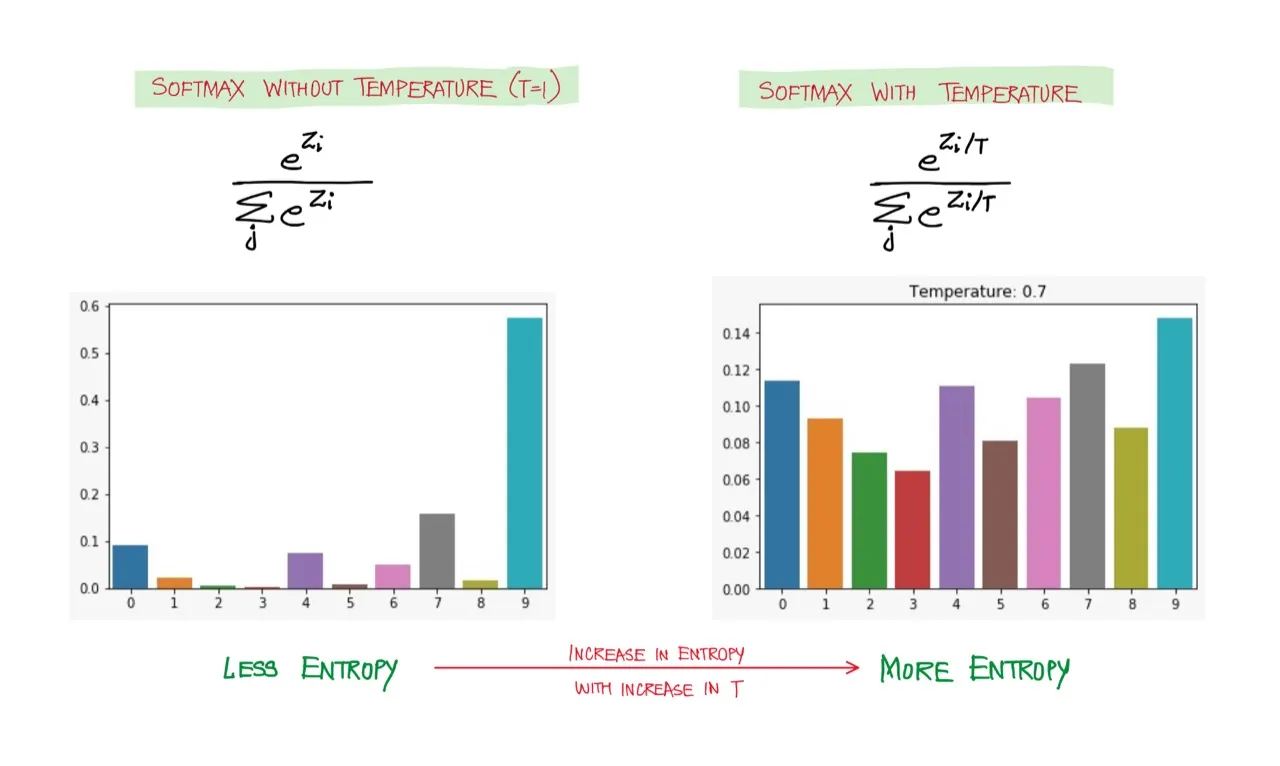

In [ ]:
class VanillaRAG:
    def __init__(self, model_name, openai_api_key):
        os.environ["OPENAI_API_KEY"] = openai_api_key
        self.embeddings = OpenAIEmbeddings()
        if model_name == "OPENAI":
          self.llm = OpenAI(temperature=0.7)
        else:
          # self.embeddings = HuggingFaceBgeEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
          # self.llm = Ollama(model = model_name, temperature = 0.1

        # )
          pass
        self.vectorstore = None
        self.qa_chain = None
        self.model_name = model_name

    def get_model_info(self):
        """Get information about the current model"""
        return {
            "model_name": self.model_name,
            "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",
            "vector_store": "FAISS",
            "chunks_loaded": len(self.vectorstore.docstore._dict) if self.vectorstore else 0
        }

    def load_and_process_documents(self, file_paths):
        """Load documents and create vector store"""
        documents = []

        # Load documents
        for file_path in file_paths:
            loader = TextLoader(file_path)
            documents.extend(loader.load())

        # Split documents into chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        chunks = text_splitter.split_documents(documents)
        print(type(chunks))
        print(type(chunks[0]))
        print(chunks[1])
        # Create vector store
        self.vectorstore = FAISS.from_documents(chunks, self.embeddings)

        # Create QA chain (Send the query and receive response)
        self.qa_chain = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff", # stuff-> put all retrieved documents into prompt all together, map_reduce-> summarize each document and then combine summaries , refine-> iteratively refines the answer using each document(one at a time)
            retriever=self.vectorstore.as_retriever(search_kwargs={"k": 3}),
            return_source_documents=True
        )

        return f"Processed {len(chunks)} chunks from {len(file_paths)} documents"

    def query(self, question):
        """Query the RAG system"""
        if not self.qa_chain:
            return "Please load documents first using load_and_process_documents()"

        try:
            print(f"Querying with Llama model: {self.model_name}")
            result = self.qa_chain({"query": question})

            return {
                "answer": result["result"],
                "source_documents": [doc.page_content[:200] + "..." for doc in result["source_documents"]],
                "model_used": self.model_name
            }
        except Exception as e:
            return f"Error during query: {str(e)}"

In [ ]:
# Initialize RAG system
# rag = VanillaRAG(model_name = "llama3.1:8b")
rag = VanillaRAG("OPENAI","OPENAI API KEY")

In [ ]:
file_paths = ["/content/document1.txt", "/content/document2.txt"]
print(rag.load_and_process_documents(file_paths))

In [ ]:
print("\nModel Information:")
info = rag.get_model_info()
for key, value in info.items():
    print(f"  {key}: {value}")


Model Information:
  model_name: llama3.1:8b
  embedding_model: sentence-transformers/all-MiniLM-L6-v2
  vector_store: FAISS
  chunks_loaded: 14


In [ ]:
test_questions = [
        "What is the main cause of climate change?",
        "What are the key renewable energy technologies mentioned?",
        "How has solar panel efficiency improved over time?"
    ]

In [ ]:
!ollama list

/bin/bash: line 1: ollama: command not found


In [ ]:
for question in test_questions:
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)

    response = rag.query(question)
    if isinstance(response, dict):
        print(f"Answer: {response['answer']}")
        print(f"Model: {response['model_used']}")
        print(f"Sources: {len(response['source_documents'])} documents")
    else:
        print(f"Error: {response}")

# GRAPH RAG Experiment Rough

In [ ]:

from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import networkx as nx
import os
import json
import re
from collections import defaultdict

class GraphRAG:
    def __init__(self, openai_api_key):
        os.environ["OPENAI_API_KEY"] = openai_api_key
        self.embeddings = OpenAIEmbeddings()
        self.llm = OpenAI(temperature=0.1)
        self.knowledge_graph = nx.Graph()
        self.entity_chunks = defaultdict(list)  # Map entities to their source chunks

        # Prompt for entity and relationship extraction
        self.extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="""
            Extract entities and relationships from the following text.
            Format your response as JSON with the following structure:
            {{
                "entities": ["entity1", "entity2", ...],
                "relationships": [
                    {{"subject": "entity1", "predicate": "relationship_type", "object": "entity2"}},
                    ...
                ]
            }}

            Text: {text}

            JSON:
            """
        )

        # Prompt for entity identification in queries
        self.entity_query_prompt = PromptTemplate(
            input_variables=["question"],
            template="""
            Identify the main entities mentioned in this question:
            Question: {question}

            Return only the entities as a comma-separated list:
            """
        )

        # Prompt for answer generation
        self.answer_prompt = PromptTemplate(
            input_variables=["question", "graph_context"],
            template="""
            Question: {question}

            Relevant information from knowledge graph:
            {graph_context}

            Based on the structured information above, provide a comprehensive answer to the question.
            Answer:
            """
        )

        self.extraction_chain = LLMChain(llm=self.llm, prompt=self.extraction_prompt)
        self.entity_query_chain = LLMChain(llm=self.llm, prompt=self.entity_query_prompt)
        self.answer_chain = LLMChain(llm=self.llm, prompt=self.answer_prompt)

    def load_and_process_documents(self, file_paths):
        """Load documents and build knowledge graph"""
        documents = []

        for file_path in file_paths:
            loader = TextLoader(file_path)
            documents.extend(loader.load())

        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        chunks = text_splitter.split_documents(documents)

        print(f"Processing {len(chunks)} chunks to build knowledge graph...")

        for i, chunk in enumerate(chunks):
            print(f"Processing chunk {i+1}/{len(chunks)}")
            self._extract_and_add_to_graph(chunk.page_content, i)

        print(f"Knowledge graph built with {self.knowledge_graph.number_of_nodes()} nodes and {self.knowledge_graph.number_of_edges()} edges")

        return f"Built knowledge graph from {len(chunks)} chunks"

    def _extract_and_add_to_graph(self, text, chunk_id):
        """Extract entities and relationships from text and add to graph"""
        try:
            # Extract entities and relationships
            extraction_result = self.extraction_chain.run(text=text)

            # Parse JSON response
            json_match = re.search(r'\{.*\}', extraction_result, re.DOTALL)
            if not json_match:
                return

            data = json.loads(json_match.group())

            # Add entities to graph
            for entity in data.get("entities", []):
                entity = entity.strip().lower()
                if entity:
                    self.knowledge_graph.add_node(entity)
                    self.entity_chunks[entity].append((chunk_id, text))

            # Add relationships to graph
            for rel in data.get("relationships", []):
                subject = rel.get("subject", "").strip().lower()
                object_entity = rel.get("object", "").strip().lower()
                predicate = rel.get("predicate", "").strip()

                if subject and object_entity and predicate:
                    self.knowledge_graph.add_edge(
                        subject,
                        object_entity,
                        relationship=predicate,
                        source_chunk=chunk_id
                    )

        except Exception as e:
            print(f"Error processing chunk {chunk_id}: {e}")
    def visualise_graph_vector_db():
      pass
    def _find_relevant_subgraph(self, entities, max_depth=2):
        """Find relevant subgraph around query entities"""
        relevant_nodes = set()
        relevant_edges = []

        for entity in entities:
            entity = entity.strip().lower()
            if entity in self.knowledge_graph:
                # Add the entity itself
                relevant_nodes.add(entity)

                # Add neighbors within max_depth
                for neighbor in nx.single_source_shortest_path_length(
                    self.knowledge_graph, entity, cutoff=max_depth
                ).keys():
                    relevant_nodes.add(neighbor)

        # Get edges between relevant nodes
        for node1 in relevant_nodes:
            for node2 in relevant_nodes:
                if self.knowledge_graph.has_edge(node1, node2):
                    edge_data = self.knowledge_graph[node1][node2]
                    relevant_edges.append((node1, node2, edge_data))

        return relevant_nodes, relevant_edges

    def _get_context_from_subgraph(self, nodes, edges):
        """Convert subgraph to textual context"""
        context_parts = []

        # Add entity information
        context_parts.append("ENTITIES:")
        for node in nodes:
            # Get source chunks for this entity
            chunks = self.entity_chunks.get(node, [])
            if chunks:
                # Use the first chunk as representative text
                context_parts.append(f"- {node.title()}: {chunks[0][1][:200]}...")

        # Add relationship information
        context_parts.append("\nRELATIONSHIPS:")
        for subject, obj, edge_data in edges:
            relationship = edge_data.get('relationship', 'related to')
            context_parts.append(f"- {subject.title()} {relationship} {obj.title()}")

        return "\n".join(context_parts)

    def query(self, question):
        """Query the Graph RAG system"""
        if self.knowledge_graph.number_of_nodes() == 0:
            return "Please load documents first using load_and_process_documents()"

        # Identify entities in the question
        entities_response = self.entity_query_chain.run(question=question)
        query_entities = [e.strip() for e in entities_response.split(',')]

        print(f"Identified entities in query: {query_entities}")

        # Find relevant subgraph
        relevant_nodes, relevant_edges = self._find_relevant_subgraph(query_entities)

        print(f"Found subgraph with {len(relevant_nodes)} nodes and {len(relevant_edges)} edges")

        # Convert subgraph to context
        graph_context = self._get_context_from_subgraph(relevant_nodes, relevant_edges)

        # Generate answer
        answer = self.answer_chain.run(
            question=question,
            graph_context=graph_context
        )

        return {
            "answer": answer,
            "entities_found": list(relevant_nodes),
            "relationships_used": len(relevant_edges),
            "graph_context": graph_context
        }

    def get_graph_stats(self):
        """Get statistics about the knowledge graph"""
        return {
            "nodes": self.knowledge_graph.number_of_nodes(),
            "edges": self.knowledge_graph.number_of_edges(),
            "connected_components": nx.number_connected_components(self.knowledge_graph),
            "average_degree": sum(dict(self.knowledge_graph.degree()).values()) / self.knowledge_graph.number_of_nodes() if self.knowledge_graph.number_of_nodes() > 0 else 0
        }

In [ ]:
rag = GraphRAG("OPENAI-API KEY")

In [ ]:
file_paths = ["document1.txt", "document2.txt"]
print(rag.load_and_process_documents(file_paths))